In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor


import warnings
warnings.filterwarnings('ignore')

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Wczytywanie i optymalizacja train_df...
Zredukowano zużycie pamięci do: 17.28 MB (oszczędność 58.3%)

Wczytywanie i optymalizacja test_df...
Zredukowano zużycie pamięci do: 5.10 MB (oszczędność 59.2%)


249

In [7]:
train_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,0.0,1.0,afternoon,0.0,1.0,1,0.13
1,1,urban,4,0.99,35,daylight,clear,1.0,0.0,evening,1.0,1.0,0,0.35
2,2,rural,4,0.63,70,dim,clear,0.0,1.0,morning,1.0,0.0,2,0.30
3,3,highway,4,0.07,35,dim,rainy,1.0,1.0,morning,0.0,0.0,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,0.0,0.0,evening,1.0,0.0,1,0.56


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int32   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int8    
 3   curvature               517754 non-null  float32 
 4   speed_limit             517754 non-null  int8    
 5   lighting                517754 non-null  category
 6   weather                 517754 non-null  category
 7   road_signs_present      517754 non-null  float32 
 8   public_road             517754 non-null  float32 
 9   time_of_day             517754 non-null  category
 10  holiday                 517754 non-null  float32 
 11  school_season           517754 non-null  float32 
 12  num_reported_accidents  517754 non-null  int8    
 13  accident_risk           517754 non-null  float32 
dtypes: c

In [10]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,517754.0,NaN,NaN,NaN,258876.5,149462.849974,0.0,129438.25,258876.5,388314.75,517753.0
road_type,517754,3,highway,173672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,517754.0,NaN,NaN,NaN,2.491511,1.120434,1.0,1.0,2.0,3.0,4.0
curvature,517754.0,NaN,NaN,NaN,0.488719,0.272497,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,NaN,NaN,NaN,46.112575,15.788521,25.0,35.0,45.0,60.0,70.0
lighting,517754,3,dim,183826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,517754,3,foggy,181463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,517754.0,NaN,NaN,NaN,0.499204,0.500001,0.0,0.0,0.0,1.0,1.0
public_road,517754.0,NaN,NaN,NaN,0.502256,0.5,0.0,0.0,1.0,1.0,1.0
time_of_day,517754,3,morning,173410,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_df.isnull().sum()

,0
id,0
road_type,0
num_lanes,0
curvature,0
speed_limit,0
lighting,0
weather,0
road_signs_present,0
public_road,0
time_of_day,0


In [12]:
def plot_cat(col: str, df: pd.DataFrame=train_df, hue: str='accident_risk', sample='full', legend: bool=False) -> None:
    df = df.copy()
    if sample != 'full':
        df = df.sample(sample)

    plt.suptitle(f"Analiza zmiennej: {col}", fontsize=16, fontweight='bold', y=1.02)

    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.boxplot(df, x=col, hue=col, y='accident_risk', palette="Set2", legend=legend)

    plt.subplot(1,2,2)
    ax = sns.countplot(df, x=col, hue=col,  palette="Set2", legend=legend)
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.show()


In [13]:
for col in train_df.select_dtypes(['float', 'int']).drop(['id','curvature', 'accident_risk'], axis=1).columns:
    print(f'\n{col}')
    print(train_df[col].unique())




road_signs_present
[0. 1.]

public_road
[1. 0.]

holiday
[0. 1.]

school_season
[1. 0.]


<Figure size 640x480 with 0 Axes>

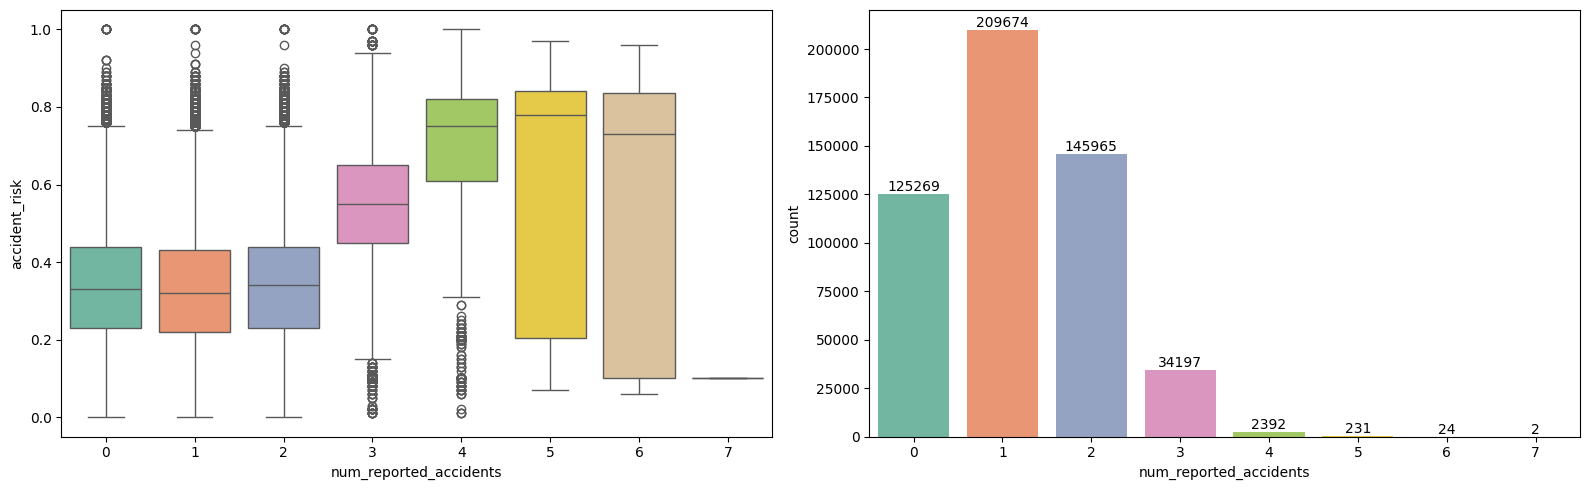

In [14]:
plot_cat('num_reported_accidents')

<Figure size 640x480 with 0 Axes>

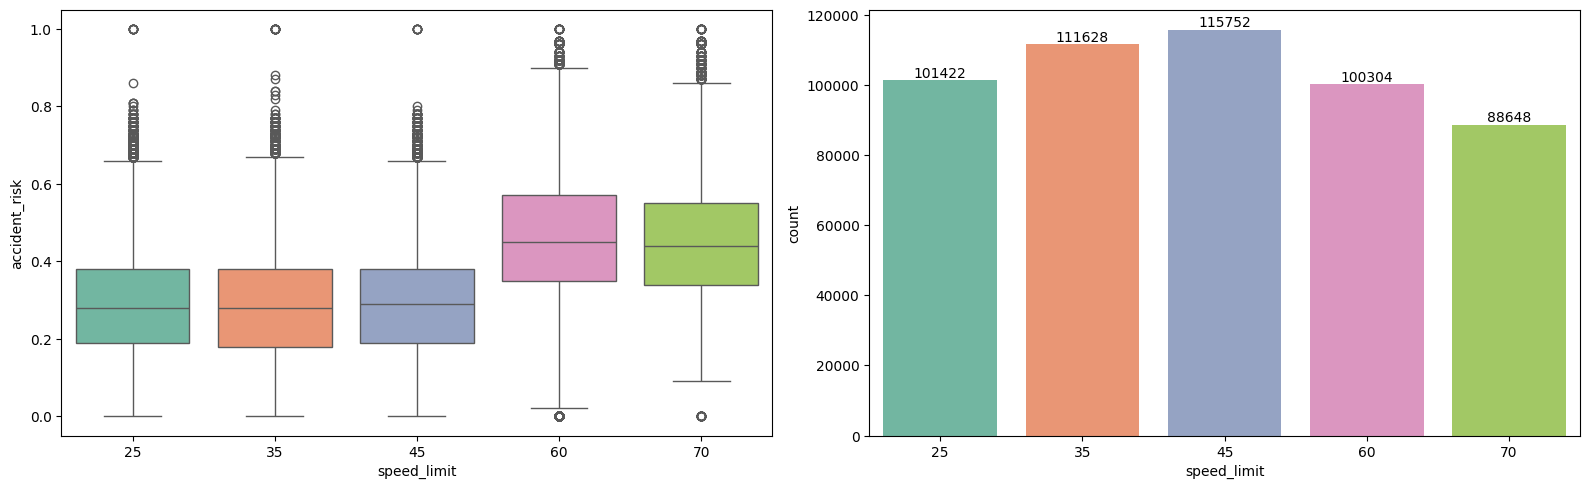

In [15]:
plot_cat('speed_limit')

<Figure size 640x480 with 0 Axes>

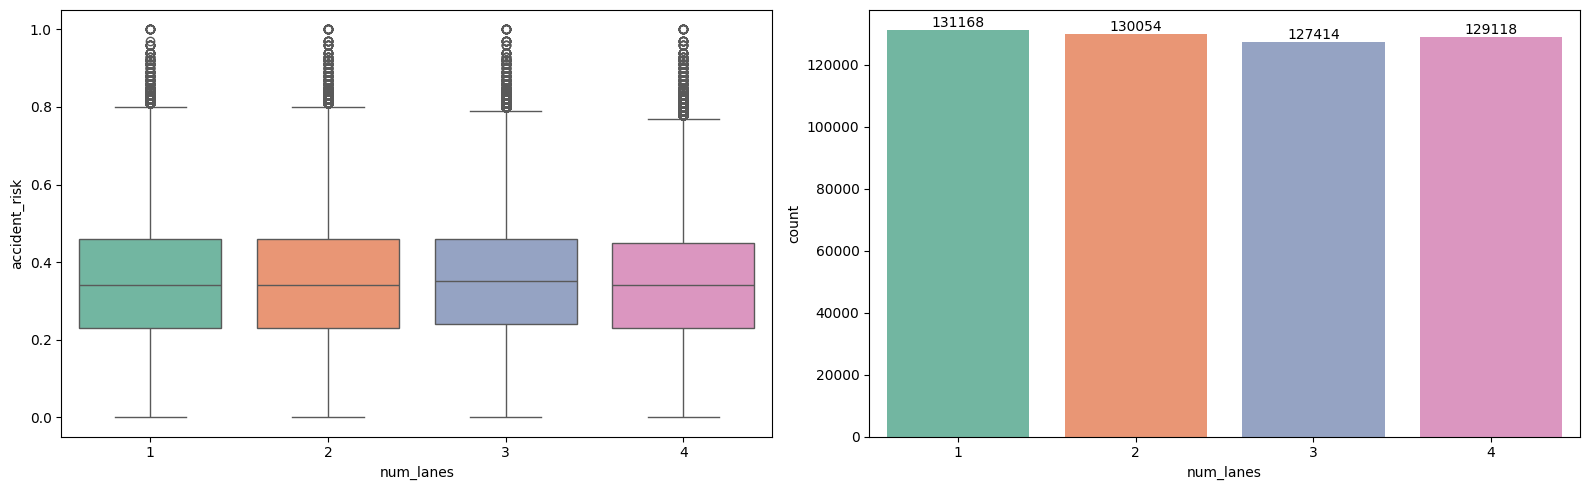

In [16]:
plot_cat('num_lanes')

<Figure size 640x480 with 0 Axes>

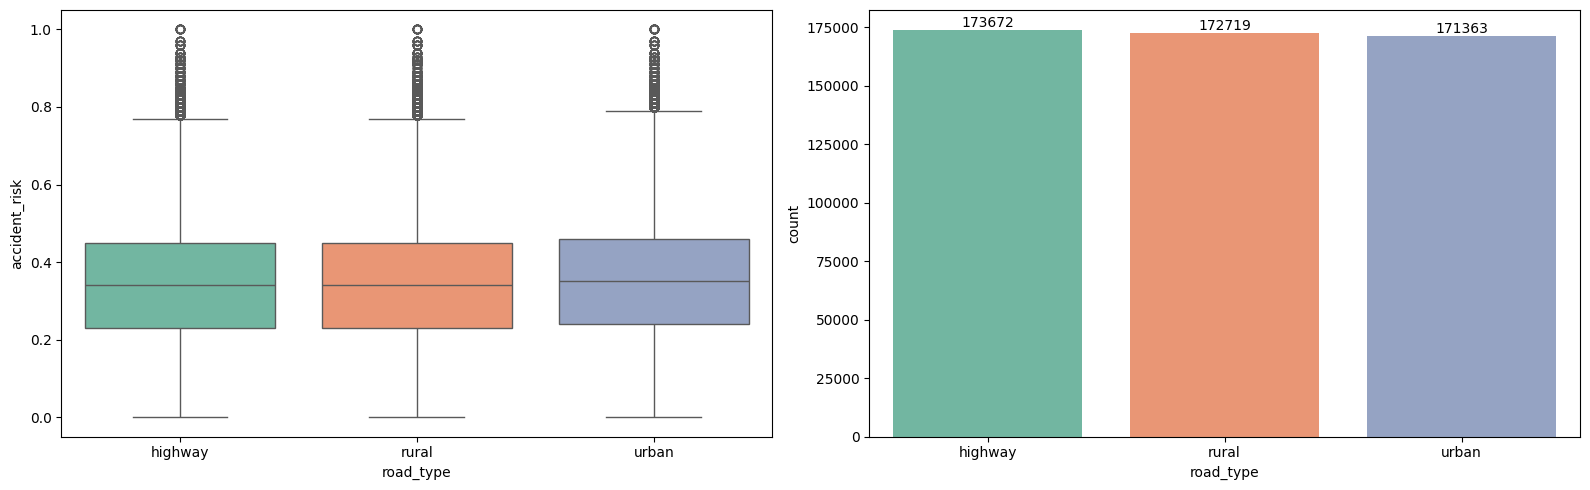

<Figure size 640x480 with 0 Axes>

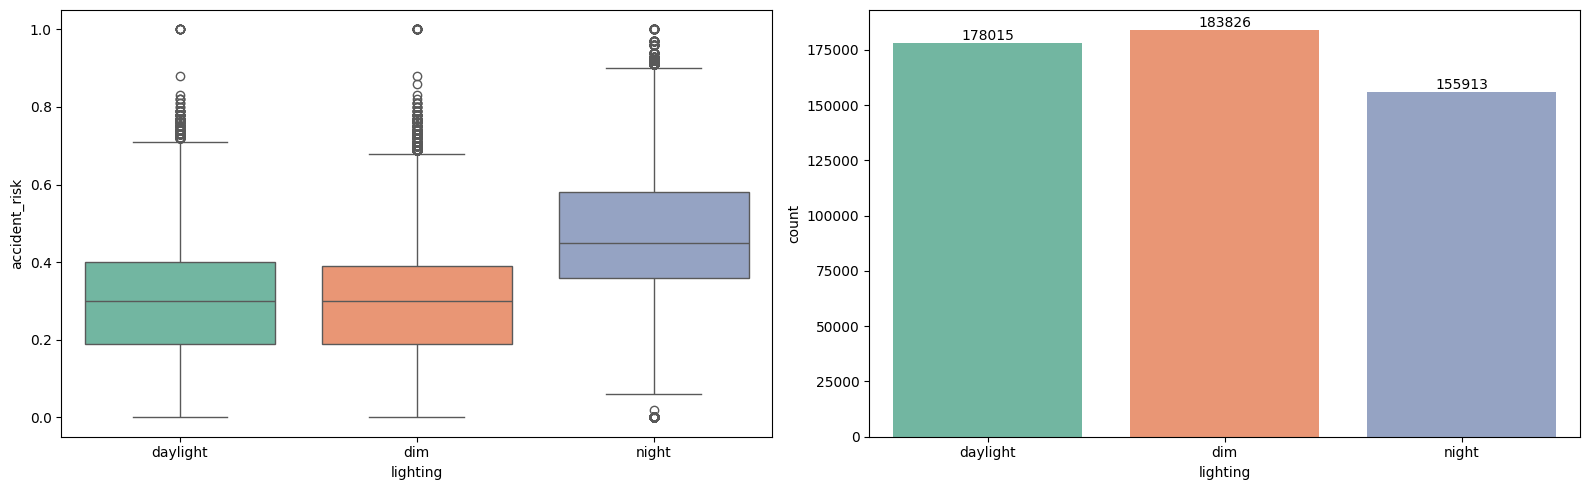

<Figure size 640x480 with 0 Axes>

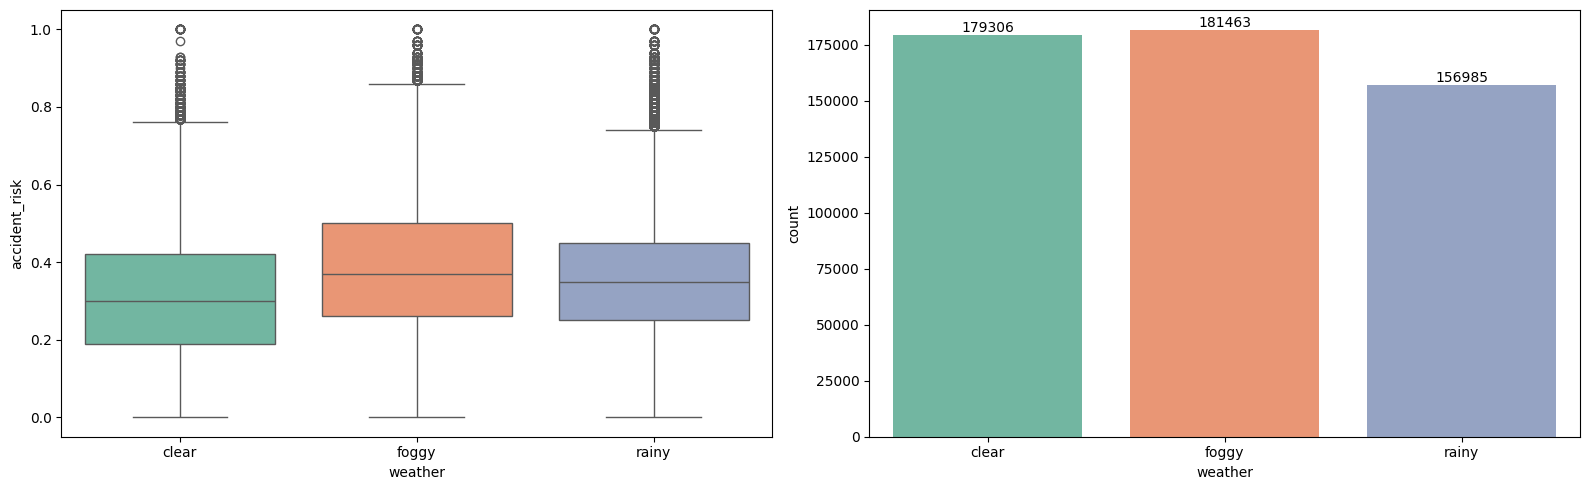

<Figure size 640x480 with 0 Axes>

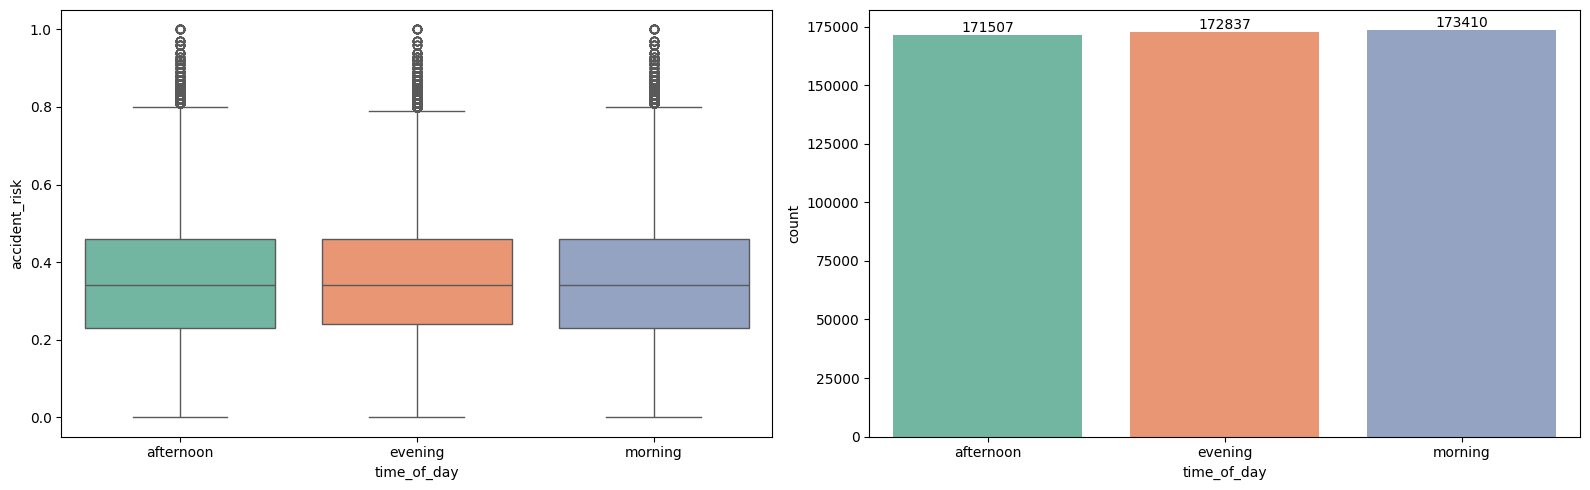

In [17]:
for col in train_df.select_dtypes(['object', 'category']).columns:
    plot_cat(col)

<Axes: xlabel='curvature', ylabel='accident_risk'>

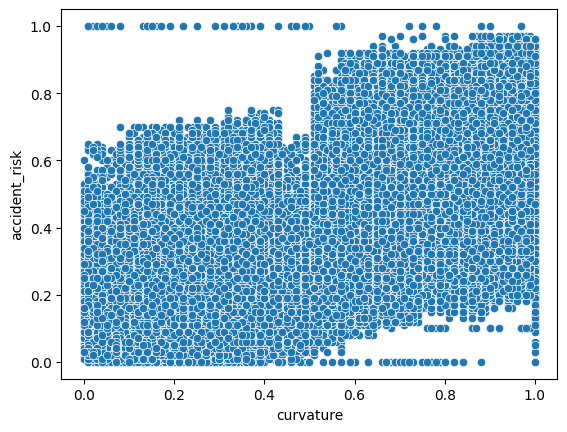

In [18]:
sns.scatterplot(train_df, x='curvature', y='accident_risk')

<Axes: xlabel='accident_risk', ylabel='Count'>

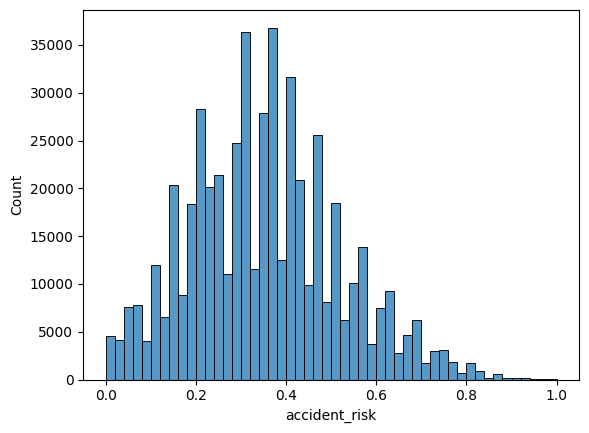

In [19]:
sns.histplot(train_df['accident_risk'], bins=50)

<Axes: xlabel='curvature', ylabel='Count'>

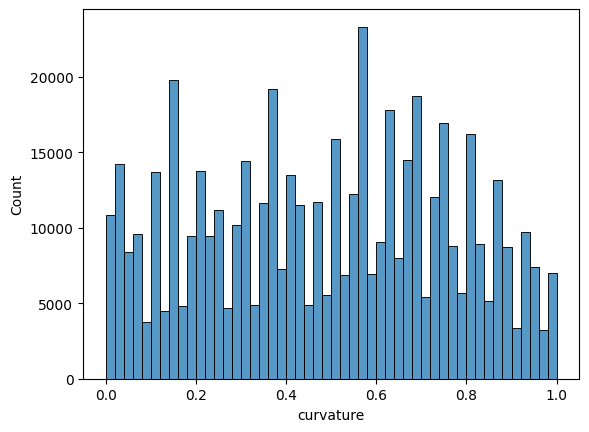

In [20]:
sns.histplot(train_df['curvature'], bins=50)

Stage 1

In [21]:
corr_matrix = train_df.select_dtypes(['int', 'float']).drop(['id'], axis=1).corr()

<Axes: >

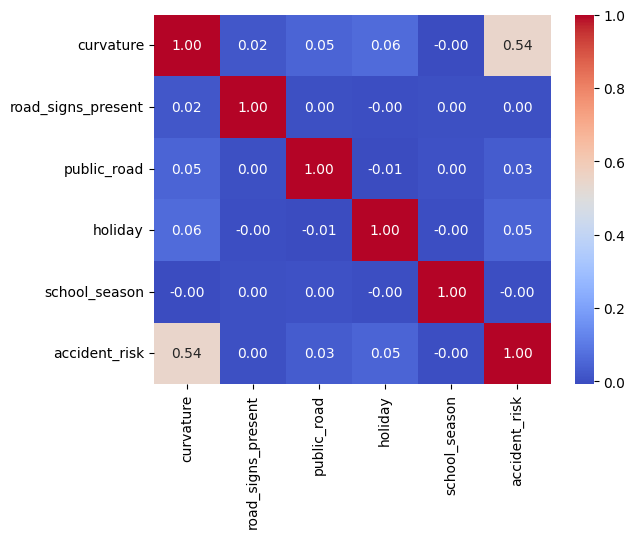

In [22]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [23]:
import statsmodels.formula.api as smf

In [24]:
X = train_df.drop(columns=['id', 'accident_risk'])
y = train_df['accident_risk']

for col in X.select_dtypes('bool').columns:
    X[col] = X[col].astype(int)

cat_cols = X.select_dtypes(['object', 'category']).columns
num_cols = X.select_dtypes(['float', 'int']).columns

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   road_type               517754 non-null  category
 1   num_lanes               517754 non-null  int8    
 2   curvature               517754 non-null  float32 
 3   speed_limit             517754 non-null  int8    
 4   lighting                517754 non-null  category
 5   weather                 517754 non-null  category
 6   road_signs_present      517754 non-null  float32 
 7   public_road             517754 non-null  float32 
 8   time_of_day             517754 non-null  category
 9   holiday                 517754 non-null  float32 
 10  school_season           517754 non-null  float32 
 11  num_reported_accidents  517754 non-null  int8    
dtypes: category(4), float32(5), int8(3)
memory usage: 13.3 MB


In [26]:
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,urban,2,0.06,35,daylight,rainy,0.0,1.0,afternoon,0.0,1.0,1
1,urban,4,0.99,35,daylight,clear,1.0,0.0,evening,1.0,1.0,0
2,rural,4,0.63,70,dim,clear,0.0,1.0,morning,1.0,0.0,2
3,highway,4,0.07,35,dim,rainy,1.0,1.0,morning,0.0,0.0,1
4,rural,1,0.58,60,daylight,foggy,0.0,0.0,evening,1.0,0.0,1


In [27]:
for col in X.select_dtypes(['object', 'category']).columns:
    print(f'{col=}\t{X[col].unique()}')

col='road_type'	['urban', 'rural', 'highway']
Categories (3, object): ['highway', 'rural', 'urban']
col='lighting'	['daylight', 'dim', 'night']
Categories (3, object): ['daylight', 'dim', 'night']
col='weather'	['rainy', 'clear', 'foggy']
Categories (3, object): ['clear', 'foggy', 'rainy']
col='time_of_day'	['afternoon', 'evening', 'morning']
Categories (3, object): ['afternoon', 'evening', 'morning']


In [28]:
def plot_resiudals(y_true, y_pred):
    sns.scatterplot(x=y_true, y=y_true-y_pred)

In [29]:
# test_df = test_df.drop(columns=['id'])

In [30]:
X_test_df = test_df
for col in X_test_df.select_dtypes('bool').columns:
    X_test_df[col] = X_test_df[col].astype(int)

In [31]:
X_test_df

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,1.0,1.0,afternoon,1.0,1.0,1
1,517755,urban,3,0.04,45,dim,foggy,1.0,0.0,afternoon,1.0,0.0,0
2,517756,urban,2,0.59,35,dim,clear,1.0,0.0,afternoon,1.0,1.0,1
3,517757,rural,4,0.95,35,daylight,rainy,0.0,0.0,afternoon,0.0,0.0,2
4,517758,highway,2,0.86,35,daylight,clear,1.0,0.0,evening,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172580,690334,rural,2,0.01,45,dim,rainy,0.0,0.0,afternoon,1.0,1.0,2
172581,690335,rural,1,0.74,70,daylight,foggy,0.0,1.0,afternoon,0.0,0.0,2
172582,690336,urban,2,0.14,70,dim,clear,0.0,0.0,evening,1.0,1.0,1
172583,690337,urban,1,0.09,45,daylight,foggy,1.0,1.0,morning,0.0,1.0,0


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Problem: Mieszane typy (bool, str, NaN) w kolumnach kategorycznych uniemożliwiają kodowanie.
# Rozwiązanie: Konwersja na string i użycie SimpleImputer w pipeline.

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Kopiujemy dane i upewniamy się, że kolumny kategoryczne mają jednolity typ (string)
X_processed = X.copy()
X_test_processed = X_test_df.copy()

for col in cat_cols:
    X_processed[col] = X_processed[col].astype(str)
    if col in X_test_processed.columns:
        X_test_processed[col] = X_test_processed[col].astype(str)

# Usuwamy wiersze z brakującym y (występuje 1 taki przypadek w zbiorze treningowym)
mask = y.notna()
X_final = X_processed[mask]
y_final = y[mask]

X_transformed = preprocessor.fit_transform(X_final)
X_test_transformed = preprocessor.transform(X_test_processed)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_final, test_size=0.2, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
mse = mean_squared_error(y_test, rfr.predict(X_test))
print(f'MSE: {mse:.4f}')

MSE: 0.0144


In [35]:
mae = mean_absolute_error(y_test, rfr.predict(X_test))
print(f'MAE: {mae:.4f}')

MAE: 0.0974


In [36]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [37]:
mae = mean_absolute_error(y_test, model.predict(X_test))
mse = mean_squared_error(y_test, model.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.01423702632707331
mae=0.09818570887035717


Stage 2

<Axes: >

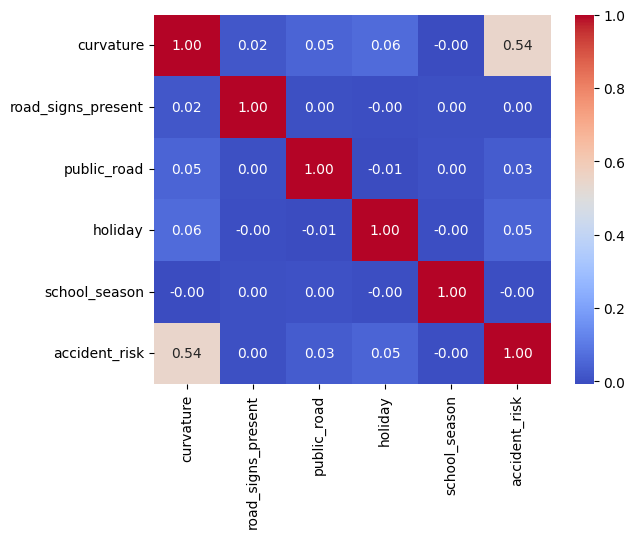

In [38]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [39]:
train_df['curvature_speed_limit_ratio'] = train_df['curvature'] / (train_df['speed_limit'] + 1)
train_df['curvature_num_lanes_ratio'] = train_df['curvature'] / (train_df['num_lanes'] + 1)
train_df['speed_limit_num_lanes_ratio'] = train_df['speed_limit'] / (train_df['num_lanes'] + 1)

test_df['curvature_speed_limit_ratio'] = test_df['curvature'] / (test_df['speed_limit'] + 1)
test_df['curvature_num_lanes_ratio'] = test_df['curvature'] / (test_df['num_lanes'] + 1)
test_df['speed_limit_num_lanes_ratio'] = test_df['speed_limit'] / (test_df['num_lanes'] + 1)

<Axes: >

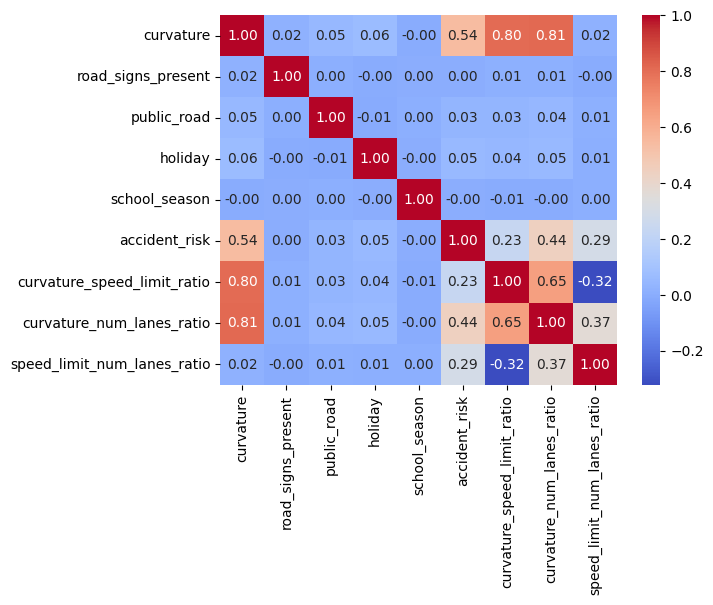

In [40]:
corr_matrix = train_df.select_dtypes(['float', 'int']).drop('id', axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

<Axes: xlabel='curvature_speed_limit_ratio', ylabel='curvature_num_lanes_ratio'>

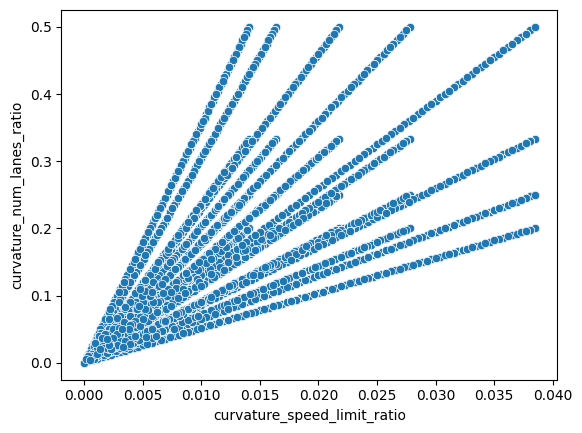

In [56]:
sns.scatterplot(train_df, x='curvature_speed_limit_ratio', y='curvature_num_lanes_ratio')

<Axes: >

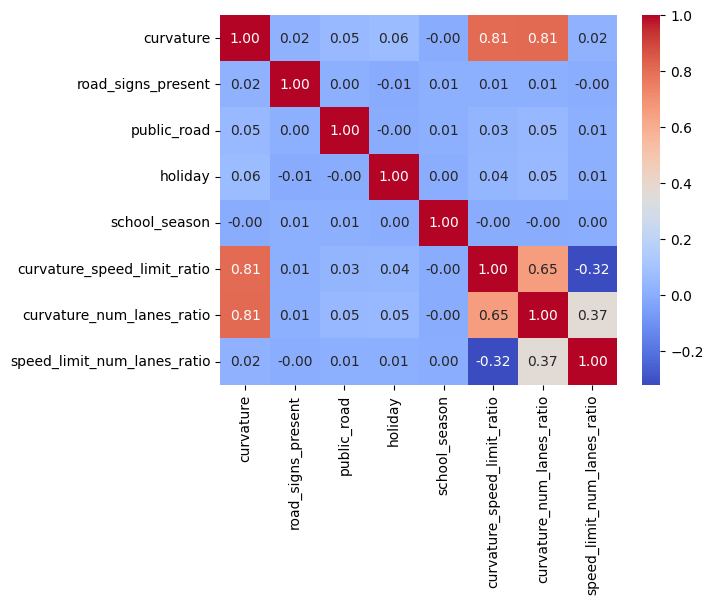

In [41]:
corr_matrix = test_df.select_dtypes(['float', 'int']).drop('id', axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [42]:
X = train_df.drop(columns=['id', 'accident_risk'])
y = train_df['accident_risk']

for col in X.select_dtypes('bool').columns:
    X[col] = X[col].astype(int)

cat_cols = X.select_dtypes(['object', 'category']).columns
num_cols = X.select_dtypes(['float', 'int']).columns

In [43]:
X_test_df = test_df.drop(columns=['id'])

for col in X_test_df.select_dtypes('bool').columns:
    X_test_df[col] = X_test_df[col].astype(int)

cat_cols = X.select_dtypes(['object', 'category']).columns
num_cols = X.select_dtypes(['float', 'int']).columns

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

cat_pipe = make_pipeline(
    OneHotEncoder()
    # OrdinalEncoder()
)
num_pipe = make_pipeline(
    StandardScaler()
    # MinMaxScaler()
)

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

X_transformed = preprocessor.fit_transform(X)
X_test_df = preprocessor.transform(X_test_df)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

Ridge()

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_test, ridge.predict(X_test))
mse = mean_squared_error(y_test, ridge.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.007120657318478498
mae=0.06692750697979293


In [49]:
result = []

for _ in range(500):
    idxs = np.random.choice(X_test_df.shape[0], size=1000, replace=True)
    sample = X_test_df[idxs]
    result.append(ridge.predict(sample))

In [50]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# model = rfr

mae = mean_absolute_error(y_test, rfr.predict(X_test))
mse = mean_squared_error(y_test, rfr.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.004424227764139542
mae=0.05143822508191611


In [51]:
from xgboost import XGBRegressor

# Inicjalizacja modelu
model_xgb = XGBRegressor(
    n_estimators=100,   # Liczba drzew
    learning_rate=0.1,  # Tempo uczenia (eta)
    max_depth=5,        # Głębokość drzewa
    random_state=42
)

# Uczenie
model_xgb.fit(X_train, y_train)

# Przewidywanie
y_pred = model_xgb.predict(X_test)

In [52]:
result = []

for _ in range(500):
    idxs = np.random.choice(X_test_df.shape[0], size=1000, replace=True)
    sample = X_test_df[idxs]
    result.append(model_xgb.predict(sample))

<Axes: ylabel='Count'>

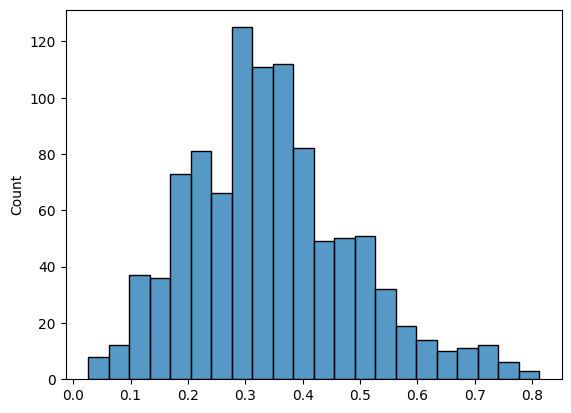

In [53]:
sns.histplot(result[0])

In [54]:
mae = mean_absolute_error(y_test, model_xgb.predict(X_test))
mse = mean_squared_error(y_test, model_xgb.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.0039344229735434055
mae=0.048706840723752975


In [55]:
from lightgbm import LGBMRegressor
model_lgbm = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,      # Kluczowy parametr w LightGBM
    random_state=42,
    verbose=-1          # Wyłącza zbędne komunikaty
)

model_lgbm.fit(X_train, y_train)
mae = mean_absolute_error(y_test, model_lgbm.predict(X_test))
mse = mean_squared_error(y_test, model_lgbm.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.004035944577343141
mae=0.04935089997895452


RFR score is closely equal other regressors, so I lost it

In [63]:
from sklearn.ensemble import VotingRegressor

estimators = [
    # ('svr', svr),
    ('lgbm', model_lgbm),
    ('xgb', model_xgb),
    ('ridge', ridge),
    # ('rfr', rfr)
]

voting_reg = VotingRegressor(estimators=estimators)
voting_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, voting_reg.predict(X_test))
mse = mean_squared_error(y_test, voting_reg.predict(X_test))
print(f'{mse=}\n{mae=}')

mse=0.0043982603375097625
mae=0.05176184682332434


In [64]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso

estimators = [
    # ('svr', svr),
    ('lgbm', model_lgbm),
    ('xgb', model_xgb),
    ('ridge', ridge),
    # ('rfr', rfr)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso()
)

stacking_reg.fit(X_train, y_train)
y_pred = stacking_reg.predict(X_test)

In [65]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'{mse=}\n{mae=}')

mse=0.02761349265282906
mae=0.13269335573096072


Best score is from XGBoost and it is less then Stacking/Voting Regressor